In [32]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 特徴量選択
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy

# https://github.com/smazzanti/mrmr
# pipでinstallはできたが、そのままimportできなかったので、
# ライブラリのソースコードをそのまま環境に設置
from libraries.mrmr import mrmr

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

import networkx as nx

# draw KM line
from lifelines import KaplanMeierFitter, CoxPHFitter


# config python file
import config

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY
INDEX_MICROARRAY = 2

from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み

In [33]:
# 臨床データ（アウトカム）
df_MB = pd.read_pickle(
    config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_MB.pkl"
).set_index("PATIENT_ID")

# 遺伝子発現データ（インプット）
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()


# important to decide X_dict name
SET_DF_MICROARRAY = (
    df_mrna_agilent_microarray,
    df_mrna_agilent_microarray_zscores_ref_all_samples,
    df_mrna_agilent_microarray_zscores_ref_diploid_samples,
)

In [34]:
df_MB.columns

Index(['LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'CELLULARITY', 'COHORT',
       'INFERRED_MENOPAUSAL_STATE', 'SEX', 'INTCLUST', 'AGE_AT_DIAGNOSIS',
       'CLAUDIN_SUBTYPE', 'THREEGENE', 'LATERALITY', 'HISTOLOGICAL_SUBTYPE',
       'SAMPLE_ID', 'GRADE', 'ONCOTREE_CODE', 'PR_STATUS', 'SAMPLE_TYPE',
       'TMB_NONSYNONYMOUS', 'CANCER_TYPE', 'CANCER_TYPE_DETAILED', 'ER_IHC',
       'HER2_SNP6', 'ER_STATUS', 'HER2_STATUS', 'TUMOR_SIZE', 'TUMOR_STAGE',
       'CHEMOTHERAPY', 'HORMONE_THERAPY', 'RADIO_THERAPY', 'BREAST_SURGERY',
       'OS_MONTHS', 'OS_STATUS', 'VITAL_STATUS', 'RFS_STATUS', 'RFS_MONTHS'],
      dtype='object')

# age data

In [35]:
# 結合

df_merged = pd.merge(
    df_MB[["OS_STATUS", "OS_MONTHS"]],
    rename_duplicated_columns(SET_DF_MICROARRAY[INDEX_MICROARRAY]),
    right_index=True,
    left_index=True,
)
df_merged["OS_STATUS_INT"] = df_merged["OS_STATUS"].replace(
    {"0:LIVING": 0, "1:DECEASED": 1}
)

In [36]:
X_dict[microarrya_type]["all_data"].keys()

dict_keys(['raw'])

In [37]:
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")

microarrya_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"

## Draw KM line

to use OS_MONTHS and OS_STATUS, read raw patient data

In [38]:
def plot_KM(target: str, threshold: float = 0, is_save: bool = False):
    ax = None
    df_merged["target_gene"] = df_merged[target].apply(
        lambda x: 1 if x > threshold else -1
    )
    plt.figure()
    kmf = KaplanMeierFitter()
    for name, group in df_merged.groupby("target_gene"):
        kmf.fit(
            group["OS_MONTHS"],
            event_observed=group["OS_STATUS_INT"],
            label="is deceased: {0}".format(name),
        )
        ax = kmf.plot(ax=ax) if ax else kmf.plot()

    make_dir(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR)

    plt.title(target)
    plt.savefig(
        "{0}/{1}.png".format(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR, target)
    ) if is_save else plt.show()

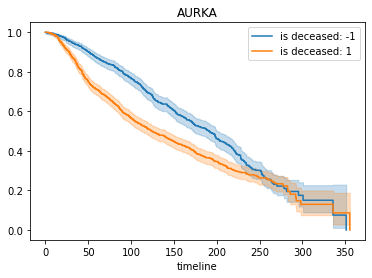

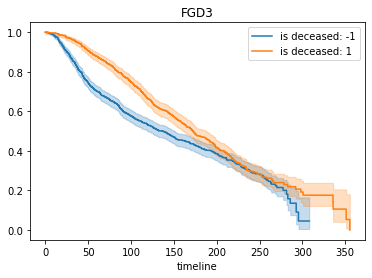

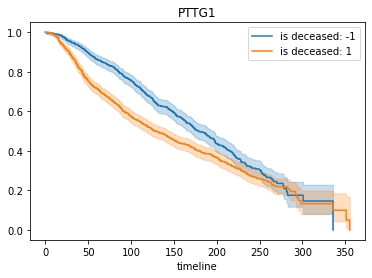

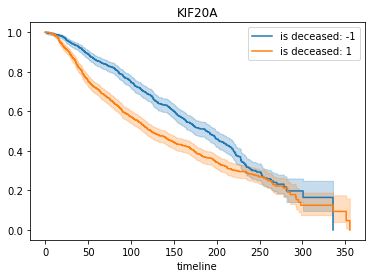

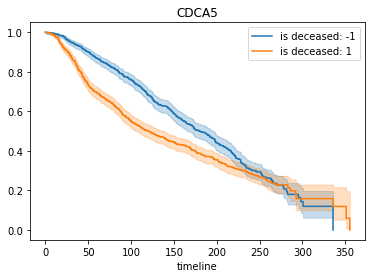

In [41]:
thresholds_list = [[0, 50], [50, 100]]

genes_list = ["AURKA", "FGD3", "PTTG1", "KIF20A", "CDCA5"]
for t in genes_list:
    plot_KM(t, 0, is_save=True)

## Draw Cox proportional hazard model

## dupulicated genes between all microarray

Iteration 1: norm_delta = 0.15013, step_size = 0.9000, log_lik = -7538.19414, newton_decrement = 26.33136, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.01464, step_size = 0.9000, log_lik = -7512.81702, newton_decrement = 0.11526, seconds_since_start = 0.2
Iteration 3: norm_delta = 0.00149, step_size = 0.9000, log_lik = -7512.70284, newton_decrement = 0.00118, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -7512.70166, newton_decrement = 0.00000, seconds_since_start = 0.3
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1904 total observations, 801 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_INT'
      baseline estimation = breslow
   number of observations = 1904
number of events observed = 1103
   partial log-likelihood = -7512.70
         time fit was run = 2022-09-22 23:52:55 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
SLC52A2     0.03       1.03       0.03            -0.03             0.08                 0.97                 1.08
SEC61A2     0.06       1.06       0.03            -0.00             0.11                 1.00                 1.12
UBE2C       0.07       1.07       0.04            -0.02             0.15                 0.98                 1.16
TBC1D31     0.07       1.08       0.03             0.02             0.13                 1.02                 1.14
F3         -0.01       0.99       0.03            -0.07             0.06                 0.93                 1.06

            cmp to     z    p   -log2(p)
covariate                               
SLC52A2       0.00  0.93 0.35       1.50
SEC61A2       0.00  1.84 0.07       3.93
UBE2C         0.00  1.52 0.13       2.96
TBC1D31       0.00  2.54 0.01       6.48
F3            0.00 -0.21 0.83       0.27
---
Concordance = 0.59
Partial AIC = 15035.40
log-likelihood ratio test = 50.98 on 5 df
-log2(p) of ll-ratio test = 30.10

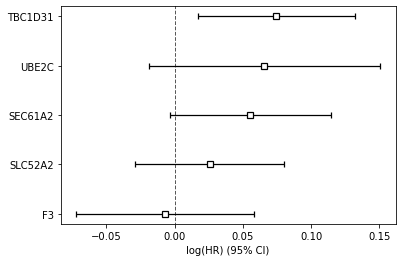

In [30]:
genes_list = ["SLC52A2", "SEC61A2", "UBE2C", "TBC1D31", "F3"]
genes_list.extend(["OS_MONTHS", "OS_STATUS_INT"])

cph = CoxPHFitter()
cph.fit(
    df_merged[genes_list],
    duration_col="OS_MONTHS",
    event_col="OS_STATUS_INT",
    show_progress=True,
)
cph.print_summary()
cph.plot()
plt.savefig(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR + "/cph.png")

Iteration 1: norm_delta = 0.20788, step_size = 0.9000, log_lik = -7538.19414, newton_decrement = 25.25032, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.01156, step_size = 0.9000, log_lik = -7513.68737, newton_decrement = 0.12837, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.00117, step_size = 0.9000, log_lik = -7513.56027, newton_decrement = 0.00129, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -7513.55898, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1904 total observations, 801 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_INT'
      baseline estimation = breslow
   number of observations = 1904
number of events observed = 1103
   partial log-likelihood = -7513.56
         time fit was run = 2022-09-22 23:56:13 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
AURKA      -0.02       0.98       0.06            -0.13             0.09                 0.88                 1.09
FGD3       -0.07       0.93       0.03            -0.14            -0.00                 0.87                 1.00
PTTG1      -0.04       0.96       0.07            -0.17             0.10                 0.84                 1.10
KIF20A      0.15       1.16       0.07             0.02             0.28                 1.02                 1.32
CDCA5       0.09       1.09       0.07            -0.04             0.22                 0.96                 1.24

            cmp to     z    p   -log2(p)
covariate                               
AURKA         0.00 -0.35 0.73       0.46
FGD3          0.00 -2.00 0.05       4.46
PTTG1         0.00 -0.53 0.60       0.74
KIF20A        0.00  2.19 0.03       5.12
CDCA5         0.00  1.31 0.19       2.39
---
Concordance = 0.61
Partial AIC = 15037.12
log-likelihood ratio test = 49.27 on 5 df
-log2(p) of ll-ratio test = 28.93

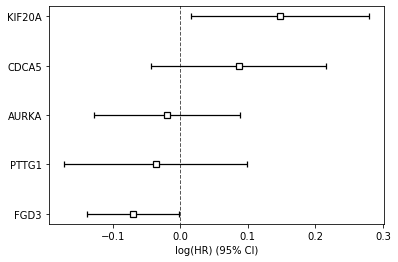

In [31]:
genes_list = ["AURKA", "FGD3", "PTTG1", "KIF20A", "CDCA5"]
genes_list.extend(["OS_MONTHS", "OS_STATUS_INT"])

cph = CoxPHFitter()
cph.fit(
    df_merged[genes_list],
    duration_col="OS_MONTHS",
    event_col="OS_STATUS_INT",
    show_progress=True,
)
cph.print_summary()
cph.plot()
plt.savefig(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR + "/cph.png")

## plot genes 

In [19]:
df_cross = pd.read_pickle(
    config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
)

<AxesSubplot:xlabel='STAT5B', ylabel='Count'>

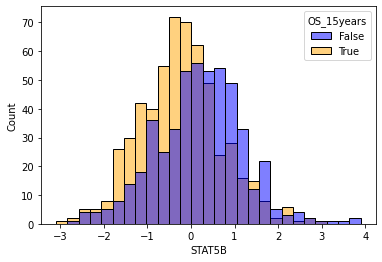

In [20]:
sns.histplot(
    x="STAT5B", data=df_cross, hue="OS_15years", palette={0: "blue", 1: "Orange"}
)

# subtypes

In [27]:
# 結合
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]

subtype = "Normal"

df_merged_subtype = pd.merge(
    df_MB[["OS_STATUS", "OS_MONTHS", "CLAUDIN_SUBTYPE"]],
    rename_duplicated_columns(SET_DF_MICROARRAY[INDEX_MICROARRAY]),
    right_index=True,
    left_index=True,
)
df_merged_subtype["OS_STATUS_INT"] = df_merged_subtype["OS_STATUS"].replace(
    {"0:LIVING": 0, "1:DECEASED": 1}
)
df_merged_subtype = df_merged_subtype[df_merged_subtype["CLAUDIN_SUBTYPE"] == subtype]

In [39]:
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")

genes_list_subtype = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
    "claudin_subtype"
]["mrmr"]["train"]["X15_{0}".format(subtype)].columns

## Draw KM line

to use OS_MONTHS and OS_STATUS, read raw patient data

In [14]:
def plot_KM(target: str, threshold: float = 0, is_save: bool = False):
    ax = None
    df_merged_subtype["target_gene"] = df_merged_subtype[target].apply(
        lambda x: 1 if x > threshold else -1
    )
    plt.figure()
    kmf = KaplanMeierFitter()
    for name, group in df_merged_subtype.groupby("target_gene"):
        kmf.fit(
            group["OS_MONTHS"],
            event_observed=group["OS_STATUS_INT"],
            label="is deceased: {0}".format(name),
        )
        ax = kmf.plot(ax=ax) if ax else kmf.plot()

    make_dir(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR)

    plt.title(target)
    plt.savefig(
        "{0}/{1}.png".format(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR, target)
    ) if is_save else plt.show()

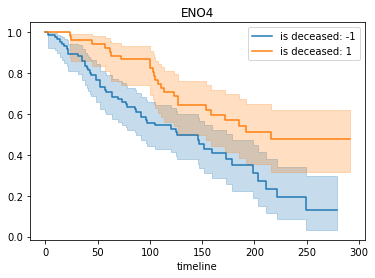

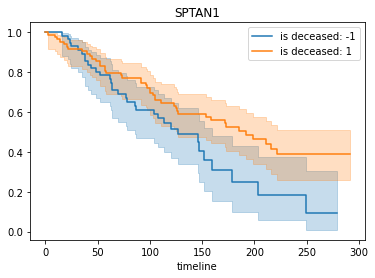

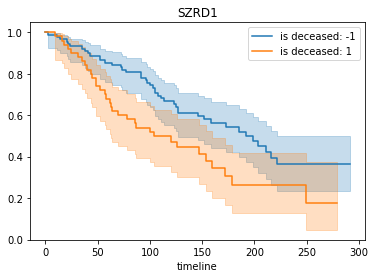

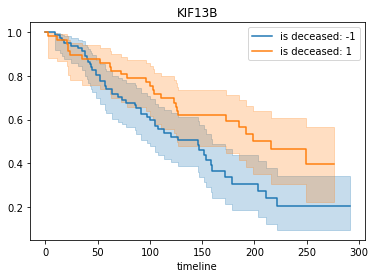

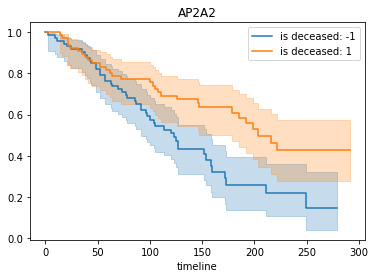

In [32]:
target_genes_list = ["ENO4", "SPTAN1", "SZRD1", "KIF13B", "AP2A2"]
for t in target_genes_list:
    plot_KM(t, 0, is_save=True)

## dupulicated genes between all microarray

In [ ]:
genes_list_subtype = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
    "claudin_subtype"
]["mrmr"]["train"]["X15_{0}".format(subtype)].columns
hoge = genes_list_subtype.to_list()
hoge.extend(["OS_MONTHS", "OS_STATUS_INT"])
hoge

Iteration 1: norm_delta = 0.80868, step_size = 0.9000, log_lik = -331.56188, newton_decrement = 22.72258, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.15470, step_size = 0.9000, log_lik = -310.98037, newton_decrement = 1.23763, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.03549, step_size = 0.9000, log_lik = -309.68519, newton_decrement = 0.09401, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00655, step_size = 1.0000, log_lik = -309.58258, newton_decrement = 0.00251, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00022, step_size = 1.0000, log_lik = -309.58002, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -309.58002, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 140 total observations, 64 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_INT'
      baseline estimation = breslow
   number of observations = 140
number of events observed = 76
   partial log-likelihood = -309.58
         time fit was run = 2022-09-21 02:16:58 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
KIF13B     -0.39       0.68       0.17            -0.73            -0.05                 0.48                 0.95
TMEM38A     0.05       1.05       0.14            -0.21             0.32                 0.81                 1.37
ZNF75D      0.24       1.27       0.14            -0.04             0.52                 0.96                 1.69
CELP        0.06       1.06       0.04            -0.03             0.15                 0.97                 1.16
TERB1       0.02       1.02       0.13            -0.23             0.28                 0.79                 1.32
OSBPL3     -0.30       0.74       0.15            -0.59            -0.00                 0.55                 1.00
SZRD1       0.25       1.29       0.13             0.00             0.51                 1.00                 1.66
RNU6ATAC    0.23       1.26       0.14            -0.04             0.51                 0.96                 1.67
ENO4       -0.09       0.92       0.16            -0.40             0.22                 0.67                 1.25
LCE1A      -0.40       0.67       0.22            -0.84             0.04                 0.43                 1.04
TP53BP1    -0.36       0.70       0.15            -0.65            -0.07                 0.52                 0.93
ZFAND2A    -0.07       0.93       0.16            -0.38             0.24                 0.69                 1.27
AP2A2      -0.03       0.97       0.16            -0.35             0.29                 0.71                 1.34
DPY19L2     0.19       1.21       0.14            -0.08             0.46                 0.92                 1.58
SPTAN1      0.07       1.07       0.15            -0.23             0.37                 0.79                 1.45
LOXL4      -0.16       0.85       0.15            -0.45             0.13                 0.64                 1.14

            cmp to     z    p   -log2(p)
covariate                               
KIF13B        0.00 -2.27 0.02       5.42
TMEM38A       0.00  0.38 0.70       0.51
ZNF75D        0.00  1.66 0.10       3.37
CELP          0.00  1.33 0.18       2.44
TERB1         0.00  0.19 0.85       0.23
OSBPL3        0.00 -1.96 0.05       4.33
SZRD1         0.00  1.97 0.05       4.36
RNU6ATAC      0.00  1.66 0.10       3.36
ENO4          0.00 -0.55 0.58       0.78
LCE1A         0.00 -1.78 0.07       3.75
TP53BP1       0.00 -2.42 0.02       6.01
ZFAND2A       0.00 -0.46 0.65       0.62
AP2A2         0.00 -0.17 0.87       0.21
DPY19L2       0.00  1.38 0.17       2.58
SPTAN1        0.00  0.44 0.66       0.60
LOXL4         0.00 -1.10 0.27       1.88
---
Concordance = 0.72
Partial AIC = 651.16
log-likelihood ratio test = 43.96 on 16 df
-log2(p) of ll-ratio test = 12.29

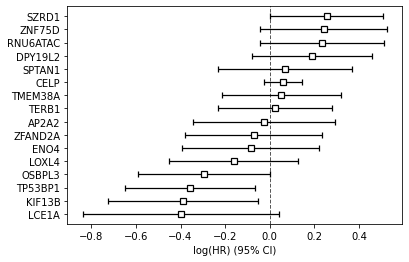

In [ ]:
cph = CoxPHFitter()
cph.fit(
    df_merged_subtype[hoge],
    duration_col="OS_MONTHS",
    event_col="OS_STATUS_INT",
    show_progress=True,
)
cph.print_summary()
cph.plot()
plt.savefig(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR + "/cph.png")

In [ ]:
from lifelines.statistics import logrank_test

# age data

In [6]:
# 結合

df_merged = pd.merge(
    df_MB[["OS_STATUS", "OS_MONTHS"]],
    rename_duplicated_columns(SET_DF_MICROARRAY[INDEX_MICROARRAY]),
    right_index=True,
    left_index=True,
)
df_merged["OS_STATUS_INT"] = df_merged["OS_STATUS"].replace(
    {"0:LIVING": 0, "1:DECEASED": 1}
)

In [15]:
X_dict[microarrya_type]["all_data"].keys()

dict_keys(['raw'])

In [18]:
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")

microarrya_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"

## Draw KM line

to use OS_MONTHS and OS_STATUS, read raw patient data

In [19]:
def plot_KM(target: str, threshold: float = 0, is_save: bool = False):
    ax = None
    df_merged["target_gene"] = df_merged[target].apply(
        lambda x: 1 if x > threshold else -1
    )
    plt.figure()
    kmf = KaplanMeierFitter()
    for name, group in df_merged.groupby("target_gene"):
        kmf.fit(
            group["OS_MONTHS"],
            event_observed=group["OS_STATUS_INT"],
            label="is deceased: {0}".format(name),
        )
        ax = kmf.plot(ax=ax) if ax else kmf.plot()

    make_dir(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR)

    plt.title(target)
    plt.savefig(
        "{0}/{1}.png".format(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR, target)
    ) if is_save else plt.show()

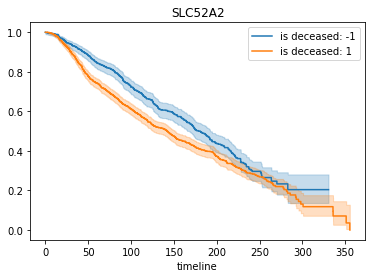

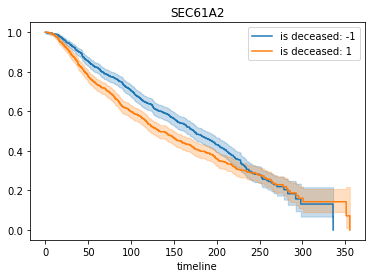

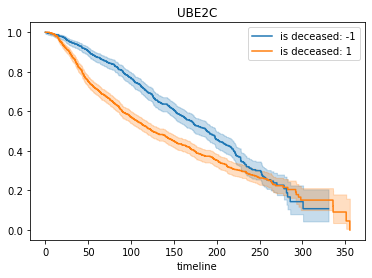

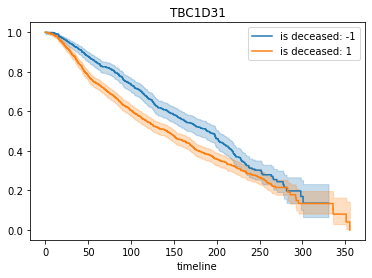

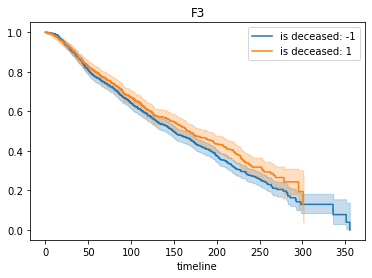

In [21]:
thresholds_list = [[0, 50], [50, 100]]

genes_list = ["SLC52A2", "SEC61A2", "UBE2C", "TBC1D31", "F3"]
for t in genes_list:
    plot_KM(t, 0, is_save=True)

thresholds:  [0, 50]
thresholds:  [50, 100]


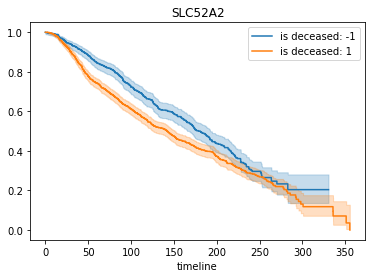

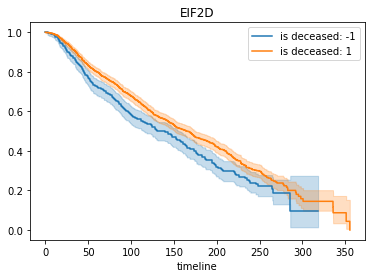

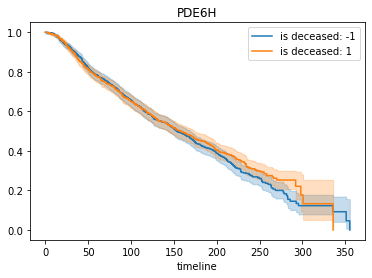

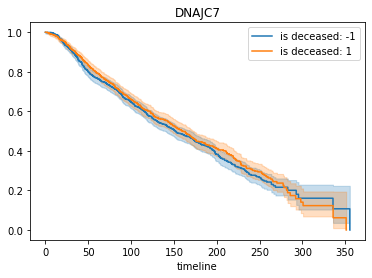

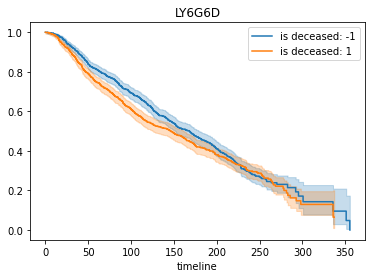

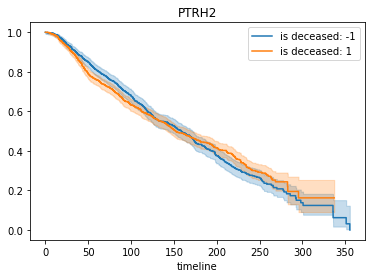

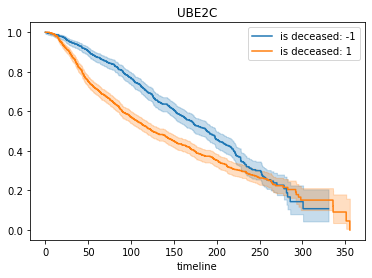

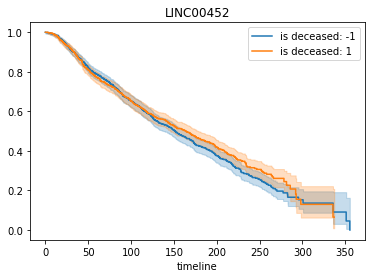

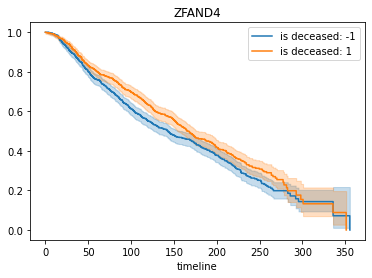

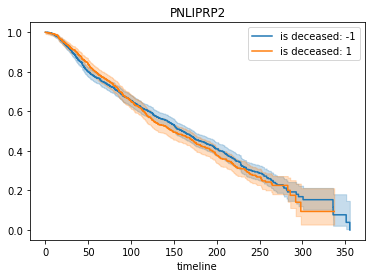

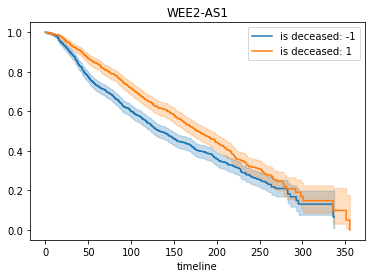

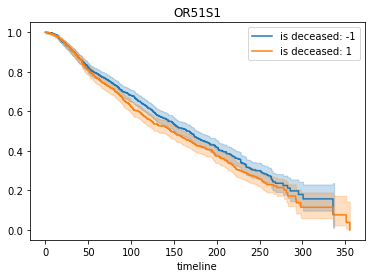

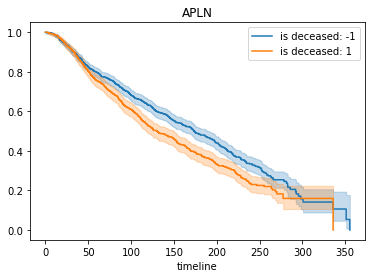

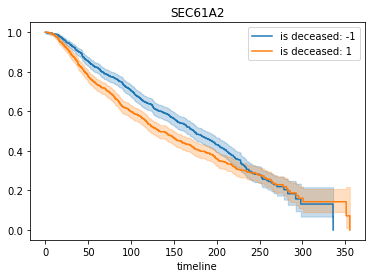

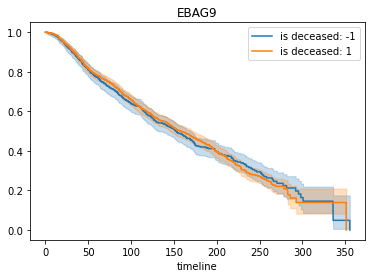

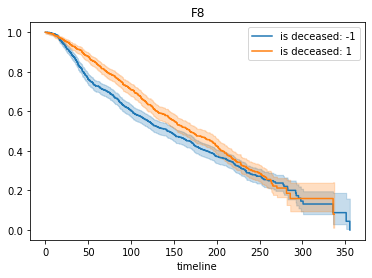

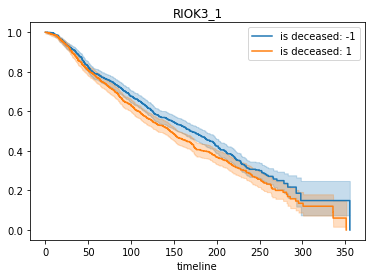

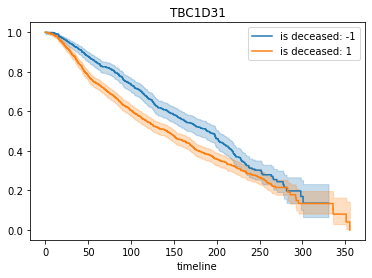

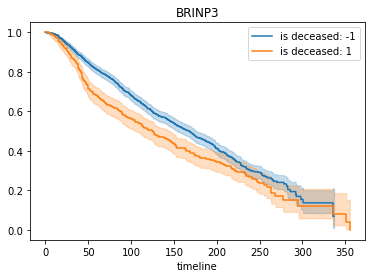

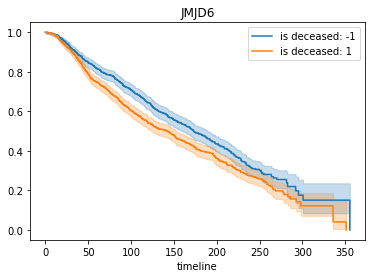

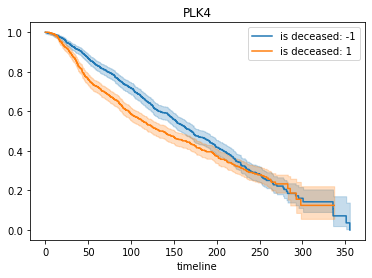

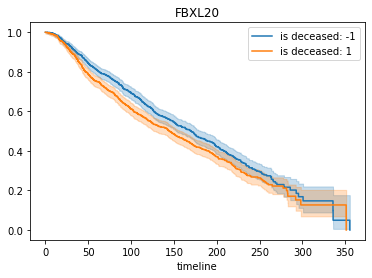

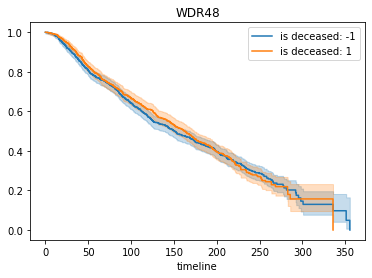

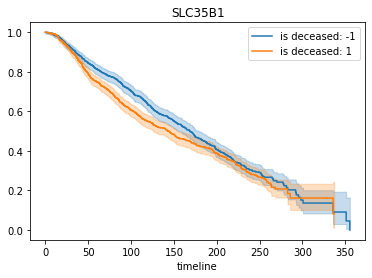

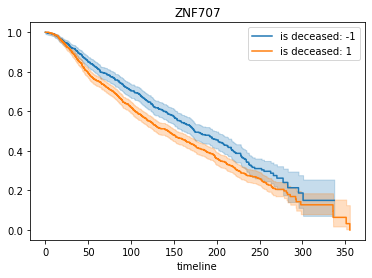

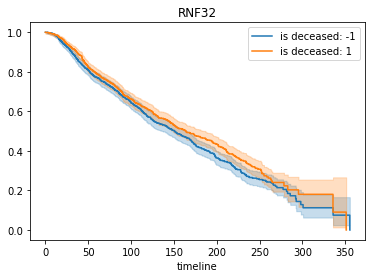

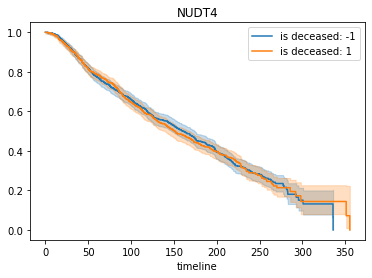

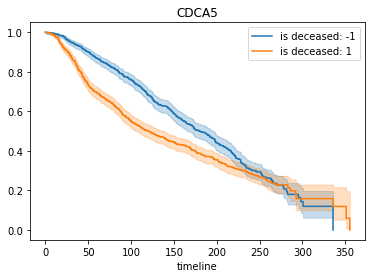

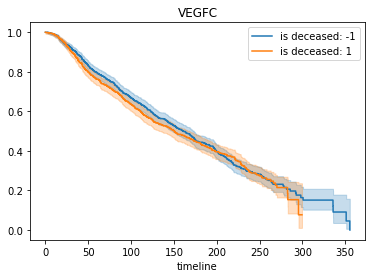

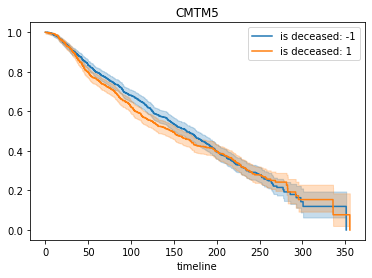

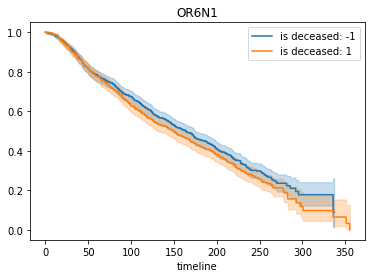

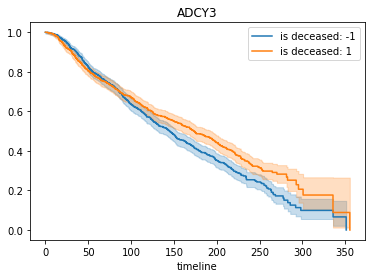

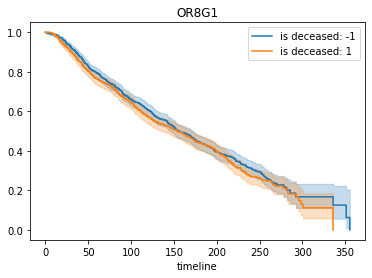

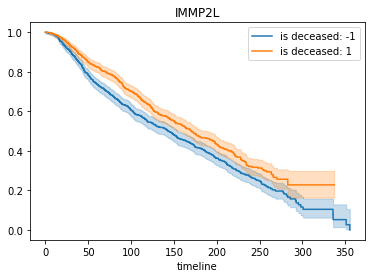

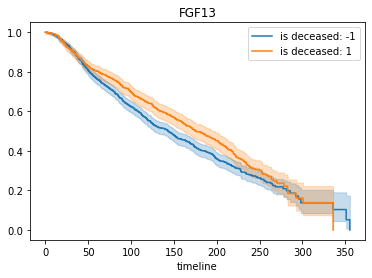

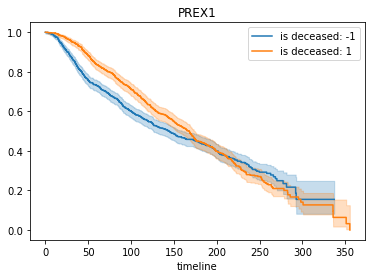

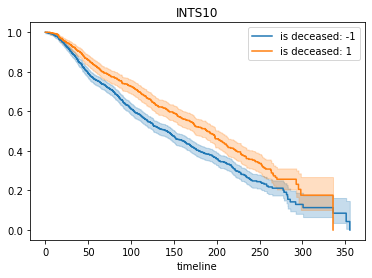

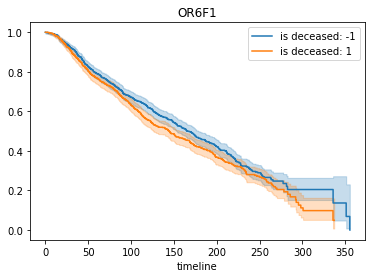

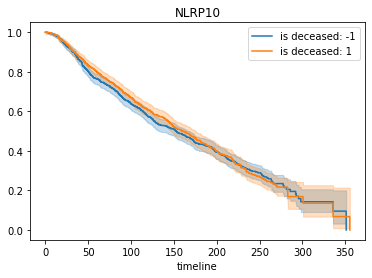

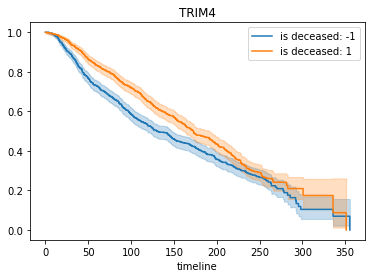

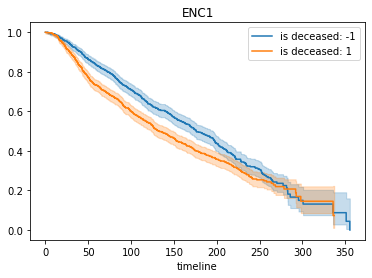

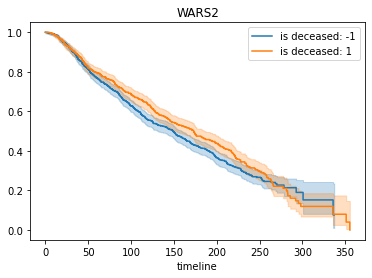

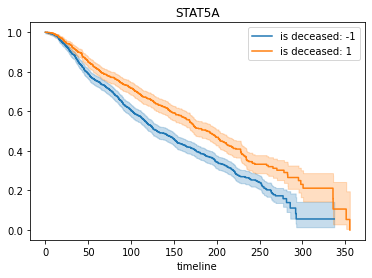

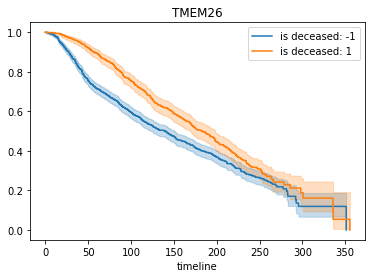

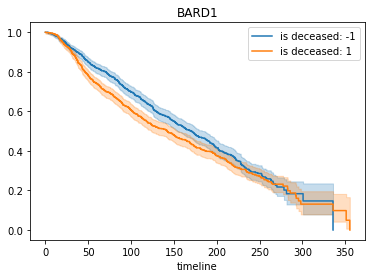

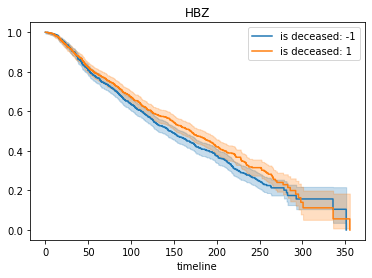

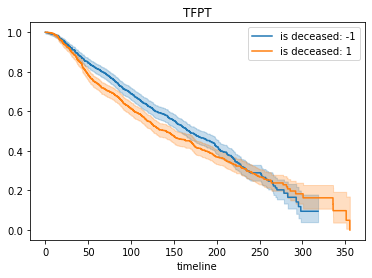

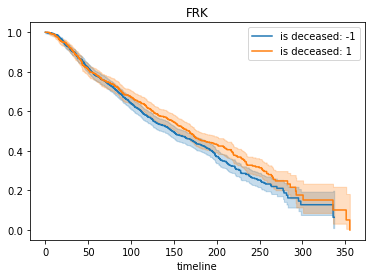

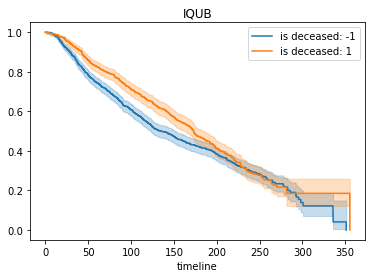

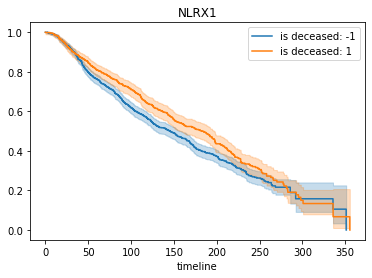

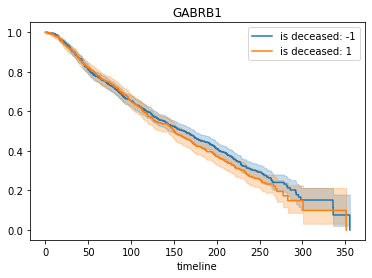

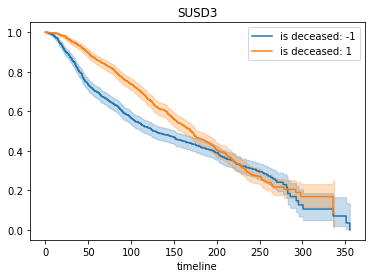

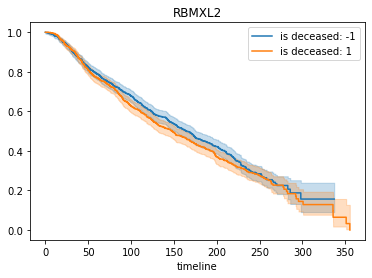

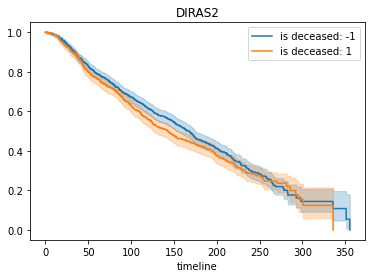

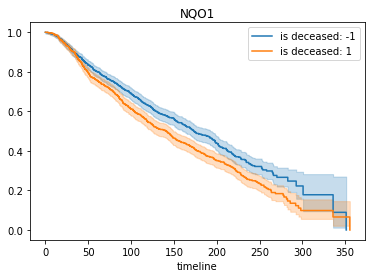

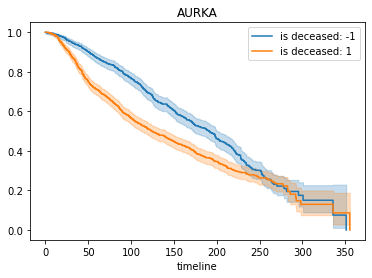

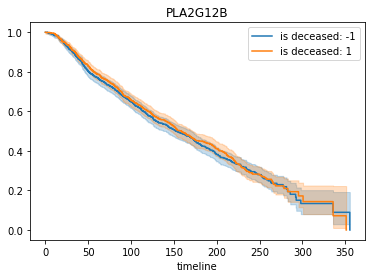

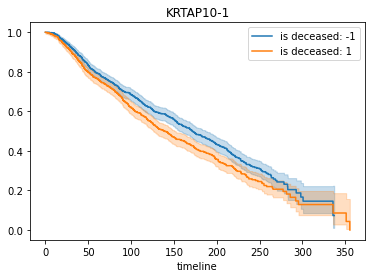

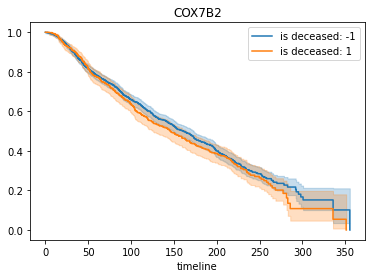

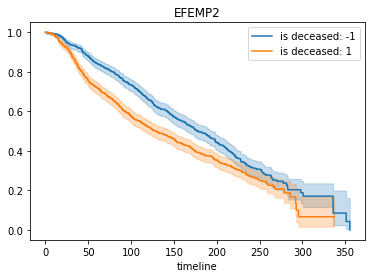

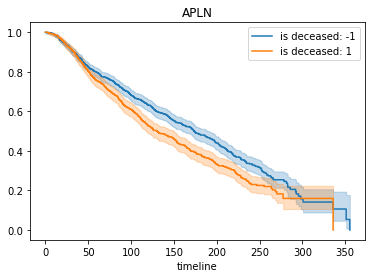

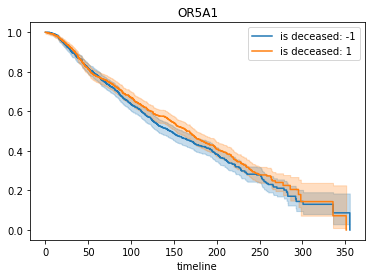

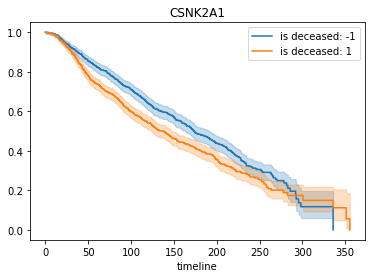

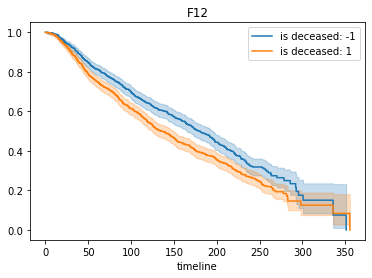

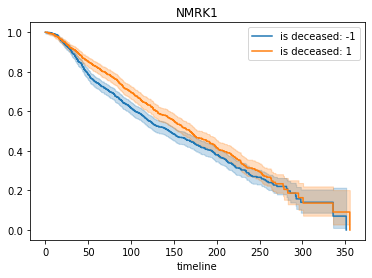

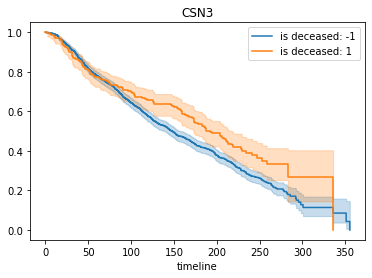

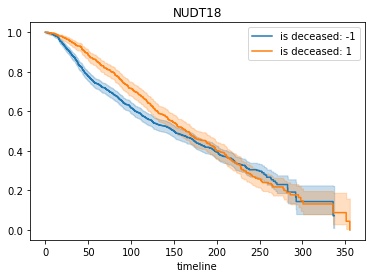

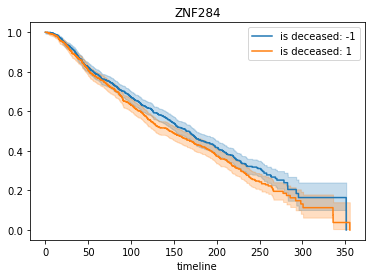

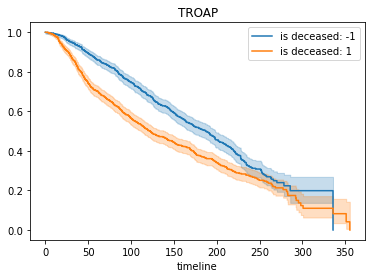

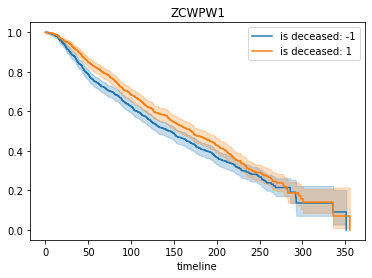

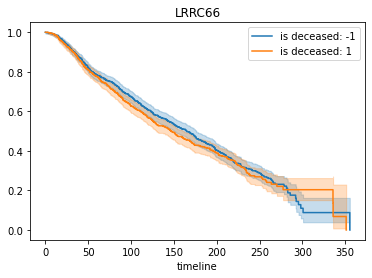

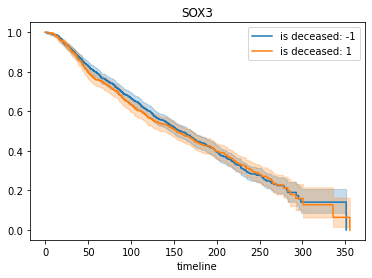

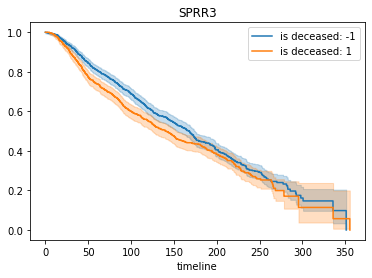

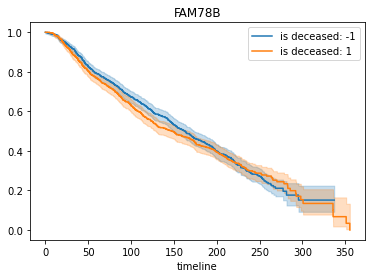

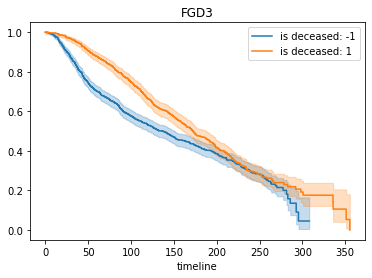

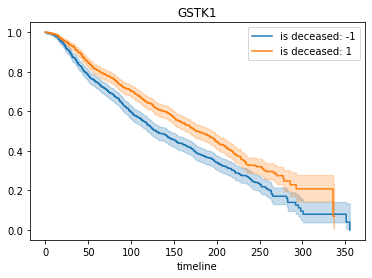

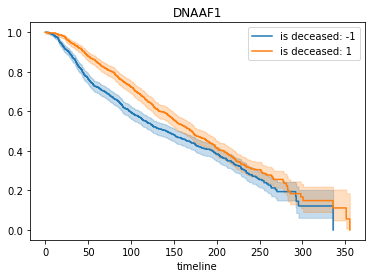

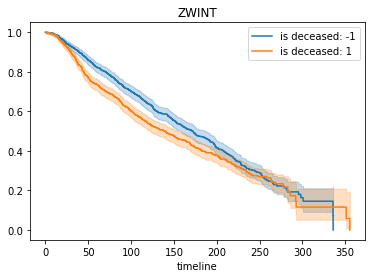

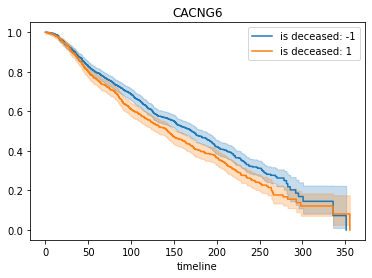

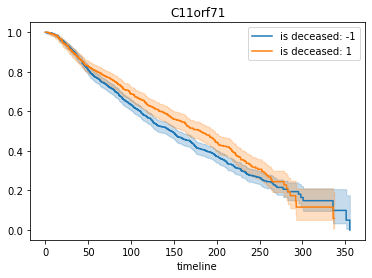

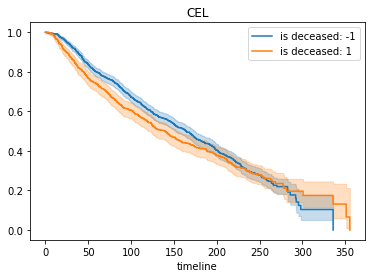

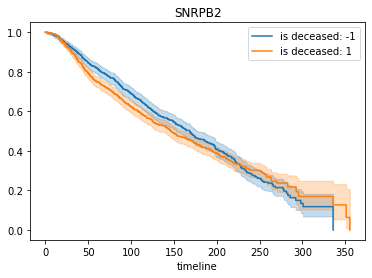

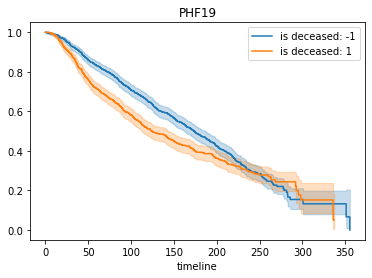

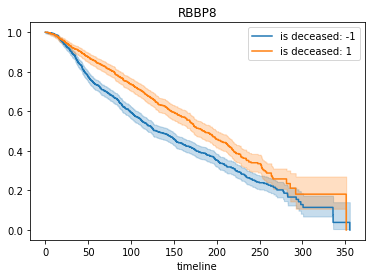

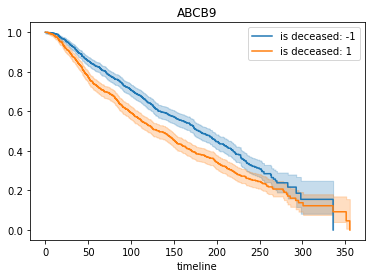

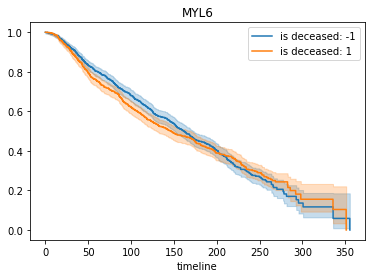

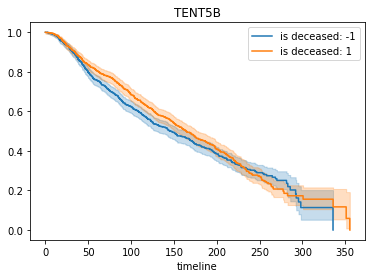

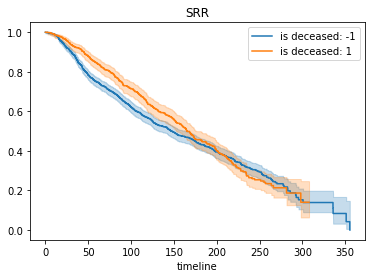

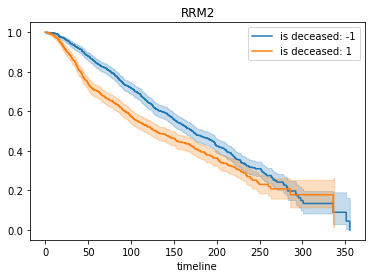

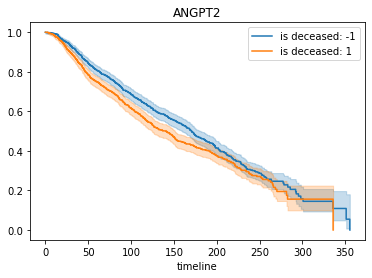

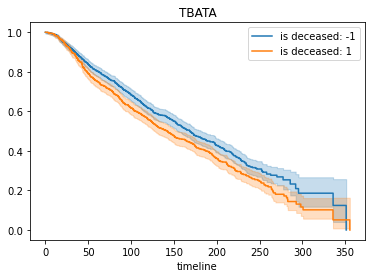

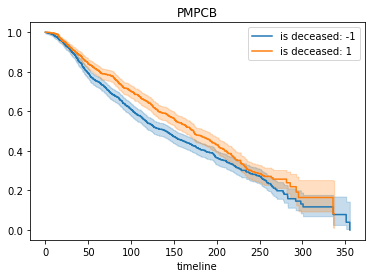

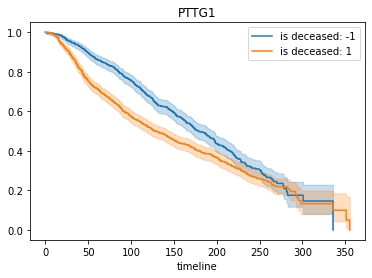

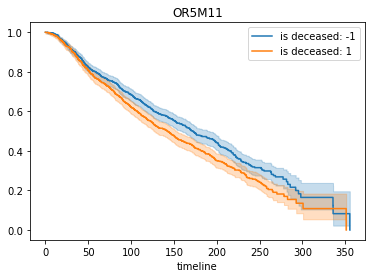

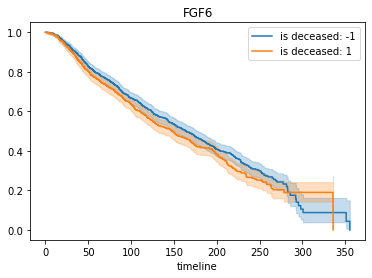

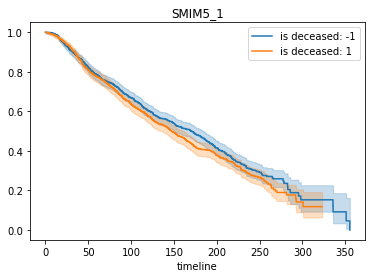

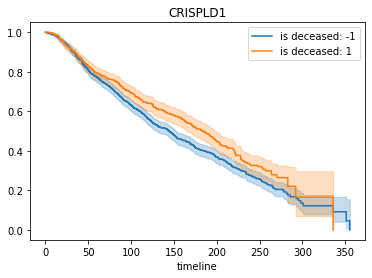

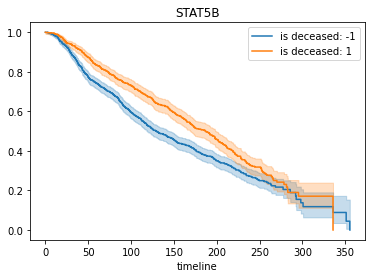

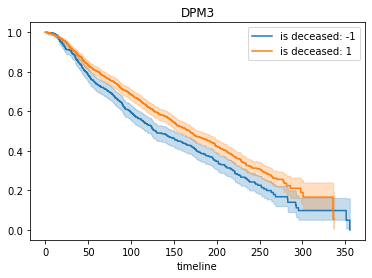

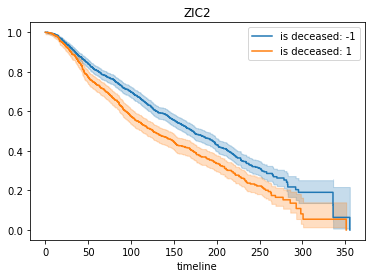

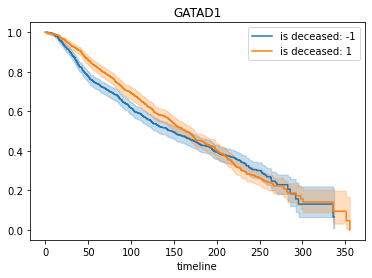

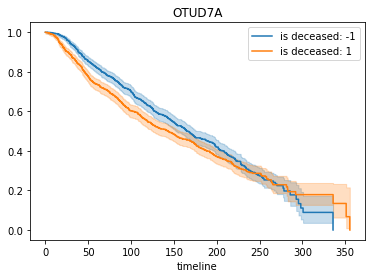

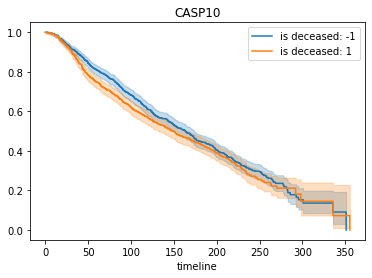

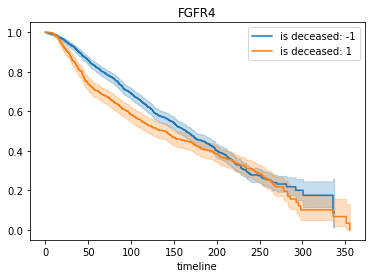

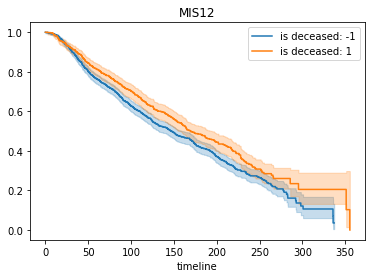

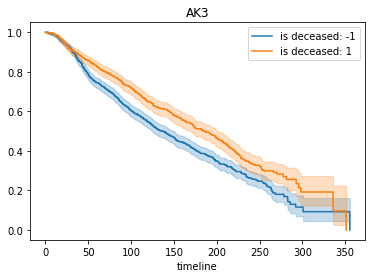

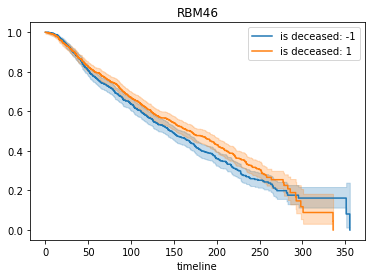

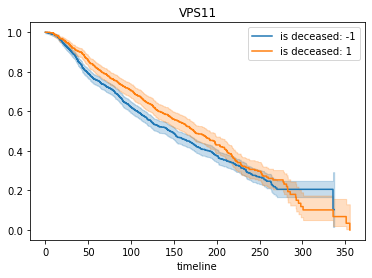

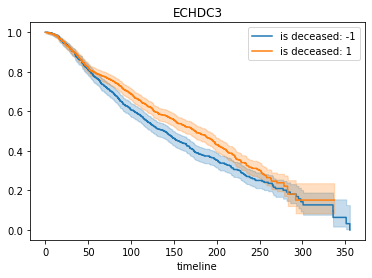

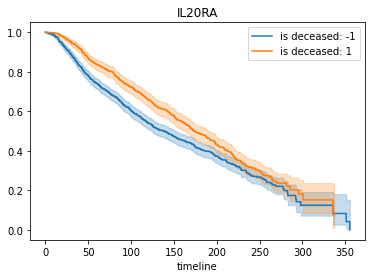

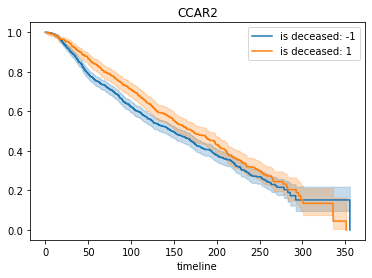

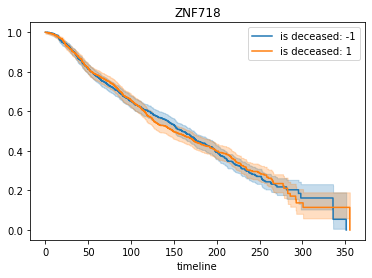

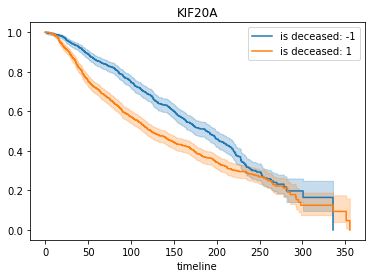

In [20]:
thresholds_list = [[0, 50], [50, 100]]

for thresholds in thresholds_list:
    print("thresholds: ", thresholds)
    prognosis_Xlabel = "X{0}_{1}to{2}".format(
        config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
    )
    genes_list = X_dict[microarrya_type][cat_name][method]["train"][prognosis_Xlabel]
    for t in genes_list:
        plot_KM(t, 0, is_save=True)

## Draw Cox proportional hazard model

## dupulicated genes between all microarray

Iteration 1: norm_delta = 0.15013, step_size = 0.9000, log_lik = -7538.19414, newton_decrement = 26.33136, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.01464, step_size = 0.9000, log_lik = -7512.81702, newton_decrement = 0.11526, seconds_since_start = 0.2
Iteration 3: norm_delta = 0.00149, step_size = 0.9000, log_lik = -7512.70284, newton_decrement = 0.00118, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -7512.70166, newton_decrement = 0.00000, seconds_since_start = 0.3
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1904 total observations, 801 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_INT'
      baseline estimation = breslow
   number of observations = 1904
number of events observed = 1103
   partial log-likelihood = -7512.70
         time fit was run = 2022-09-22 23:52:55 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
SLC52A2     0.03       1.03       0.03            -0.03             0.08                 0.97                 1.08
SEC61A2     0.06       1.06       0.03            -0.00             0.11                 1.00                 1.12
UBE2C       0.07       1.07       0.04            -0.02             0.15                 0.98                 1.16
TBC1D31     0.07       1.08       0.03             0.02             0.13                 1.02                 1.14
F3         -0.01       0.99       0.03            -0.07             0.06                 0.93                 1.06

            cmp to     z    p   -log2(p)
covariate                               
SLC52A2       0.00  0.93 0.35       1.50
SEC61A2       0.00  1.84 0.07       3.93
UBE2C         0.00  1.52 0.13       2.96
TBC1D31       0.00  2.54 0.01       6.48
F3            0.00 -0.21 0.83       0.27
---
Concordance = 0.59
Partial AIC = 15035.40
log-likelihood ratio test = 50.98 on 5 df
-log2(p) of ll-ratio test = 30.10

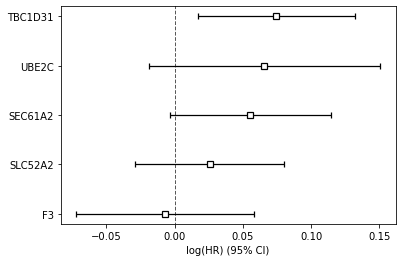

In [30]:
genes_list = ["SLC52A2", "SEC61A2", "UBE2C", "TBC1D31", "F3"]
genes_list.extend(["OS_MONTHS", "OS_STATUS_INT"])

cph = CoxPHFitter()
cph.fit(
    df_merged[genes_list],
    duration_col="OS_MONTHS",
    event_col="OS_STATUS_INT",
    show_progress=True,
)
cph.print_summary()
cph.plot()
plt.savefig(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR + "/cph.png")

Iteration 1: norm_delta = 0.20788, step_size = 0.9000, log_lik = -7538.19414, newton_decrement = 25.25032, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.01156, step_size = 0.9000, log_lik = -7513.68737, newton_decrement = 0.12837, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.00117, step_size = 0.9000, log_lik = -7513.56027, newton_decrement = 0.00129, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -7513.55898, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1904 total observations, 801 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_INT'
      baseline estimation = breslow
   number of observations = 1904
number of events observed = 1103
   partial log-likelihood = -7513.56
         time fit was run = 2022-09-22 23:56:13 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
AURKA      -0.02       0.98       0.06            -0.13             0.09                 0.88                 1.09
FGD3       -0.07       0.93       0.03            -0.14            -0.00                 0.87                 1.00
PTTG1      -0.04       0.96       0.07            -0.17             0.10                 0.84                 1.10
KIF20A      0.15       1.16       0.07             0.02             0.28                 1.02                 1.32
CDCA5       0.09       1.09       0.07            -0.04             0.22                 0.96                 1.24

            cmp to     z    p   -log2(p)
covariate                               
AURKA         0.00 -0.35 0.73       0.46
FGD3          0.00 -2.00 0.05       4.46
PTTG1         0.00 -0.53 0.60       0.74
KIF20A        0.00  2.19 0.03       5.12
CDCA5         0.00  1.31 0.19       2.39
---
Concordance = 0.61
Partial AIC = 15037.12
log-likelihood ratio test = 49.27 on 5 df
-log2(p) of ll-ratio test = 28.93

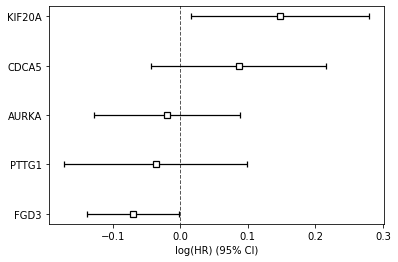

In [31]:
genes_list = ["AURKA", "FGD3", "PTTG1", "KIF20A", "CDCA5"]
genes_list.extend(["OS_MONTHS", "OS_STATUS_INT"])

cph = CoxPHFitter()
cph.fit(
    df_merged[genes_list],
    duration_col="OS_MONTHS",
    event_col="OS_STATUS_INT",
    show_progress=True,
)
cph.print_summary()
cph.plot()
plt.savefig(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR + "/cph.png")